# SONYC WSP Mini-Project

### Construction Complaint Pattern Identification

This work aims to identify patterns in construction-related noise complaints surrounding the Washington Square Park area, where there is currently an NYC DDC capital project of replacing sewers and water mains. 
June 15, 2019

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce

# Geospatial
import shapely
import geopandas as gp
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
from shapely.geometry import Point, MultiPoint
import io
from geopandas.tools import sjoin
from shapely.ops import nearest_points
from shapely.ops import cascaded_union


# Geopy for finding lat/long coordinates
import geopy
from geopy.geocoders import Nominatim
import geopy.distance
geolocator = Nominatim(user_agent = 'random')

import warnings
warnings.filterwarnings(action='once')

from sodapy import Socrata
from APPTOKEN import myToken
## Save your SOTA API Token as variable myToken in a file titled SOTAPY_APPTOKEN.py
## e.g.
## myToken = 'XXXXXXXXXXXXXXXX'

## Read in Data

### Complaints

In [67]:
complaints = pd.read_csv('../../Notebooks/Data/311DEPcomplaints.csv', 
                         usecols=['address_type',
       'community_board', 'complaint_type','created_date',
       'cross_street_1', 'cross_street_2', 'descriptor', 
        'incident_address', 'incident_zip',
       'intersection_street_1', 'intersection_street_2', 'latitude',
        'location_type', 'longitude', 'resolution_description', 'status', 'street_name'])

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
complaints = complaints[complaints['community_board'] == '02 MANHATTAN']
complaints = complaints[(complaints.descriptor == 'Noise: Construction Before/After Hours (NM1)' )|
                        (complaints.descriptor == 'Noise: Jack Hammering (NC2)' )|
                        (complaints.descriptor == 'Noise: Construction Equipment (NC1)') |
                       (complaints.descriptor == 'Construction Before/After Hours - For DEP Internal Use Only') ]
                        

### Noise Sensor Node Locations

In [69]:
nodes = pd.read_csv('../data/relevant_nodes.csv')

nodes['lonlat']=list(zip(nodes.longitude.astype(float), nodes.latitude.astype(float)))
nodes['geometry']=nodes[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
crs = {'init':'epsg:4326', 'no_defs': True}
nodes = gp.GeoDataFrame(nodes, crs=crs, geometry=nodes['geometry'])

In [70]:
nodes.drop(columns=['Unnamed: 0', 'lonlat','node_id'],inplace=True)

### Streets and Parks Shapefiles

In [71]:
## Read in streets shapefile to get street names
streets = gp.read_file('https://data.cityofnewyork.us/api/geospatial/exjm-f27b?method=export&format=GeoJSON')
streets = streets[streets.borocode == '1']
streets.drop(columns = ['rw_type', 'l_low_hn', 'pre_direct', 'st_width', 'r_zip', 'r_low_hn',
       'bike_lane', 'r_blkfc_id', 'bike_trafd', 'frm_lvl_co',
       'post_modif', 'pre_type','trafdir', 'pre_modifi', 'created', 'l_high_hn'], inplace=True)


In [72]:
## NYC Parks shapefile to get WSP
nycParks = gp.read_file('https://data.cityofnewyork.us/api/geospatial/rjaj-zgq7?method=export&format=GeoJSON')
WSP = nycParks[nycParks.index == 240][['propname', 'geometry']]
WSP['geometry'][240] = cascaded_union([nycParks['geometry'][236],nycParks['geometry'][240]])

### 1000 ft Offset from WSP

Creating a 1000 foot buffer offset from Washington Square Park and performing a spatial join with the streets shapefile to find which streets to look for that are within 1000 feet of washington square park. We will then be able to limit the search for the street construction permits and reduce the computing load of geocoding all street construction work.

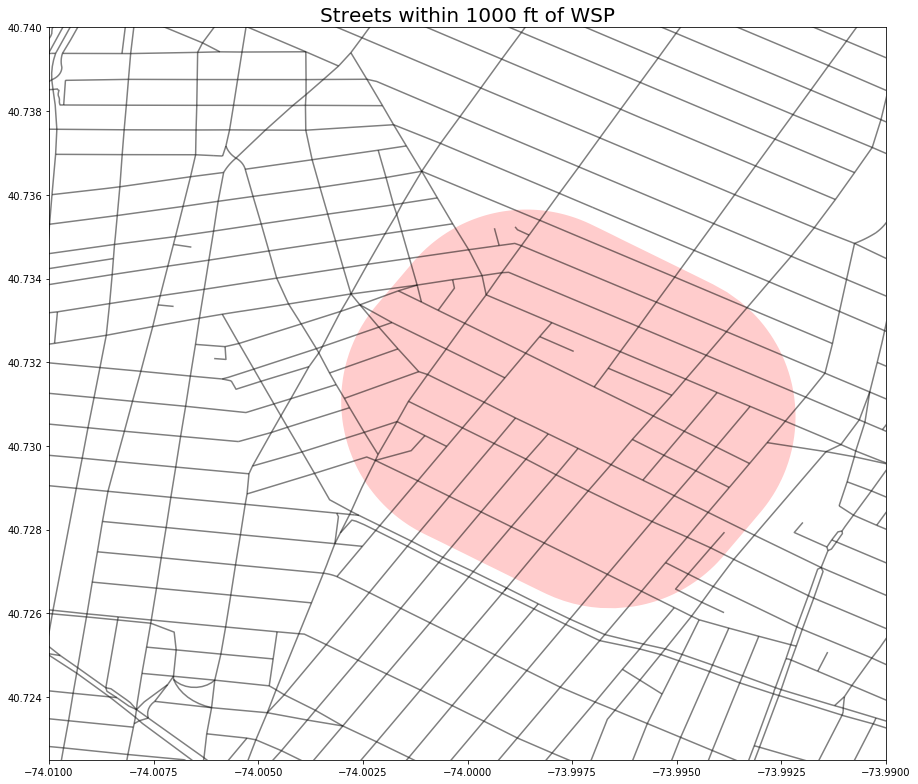

In [73]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.01,-73.99))
ax.set_ylim((40.7225,40.74))
WSP.buffer(0.0035).plot(ax=ax, color='r', alpha = 0.2)
streets.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')

plt.title("Streets within 1000 ft of WSP", size=20)
plt.show()

In [74]:
WSP_buffer = WSP.copy()
WSP_buffer['geometry'] = WSP.buffer(0.0035)

WSP_st_buffer = sjoin(streets,WSP_buffer)
WSP_st_buffer.drop(columns = ['l_blkfc_id', 'shape_leng', 'to_lvl_co', 'modified',
       'status', 'post_direc', 'r_high_hn', 'l_zip', 'snow_pri', 'borocode','physicalid','index_right',
       'propname'],inplace=True)


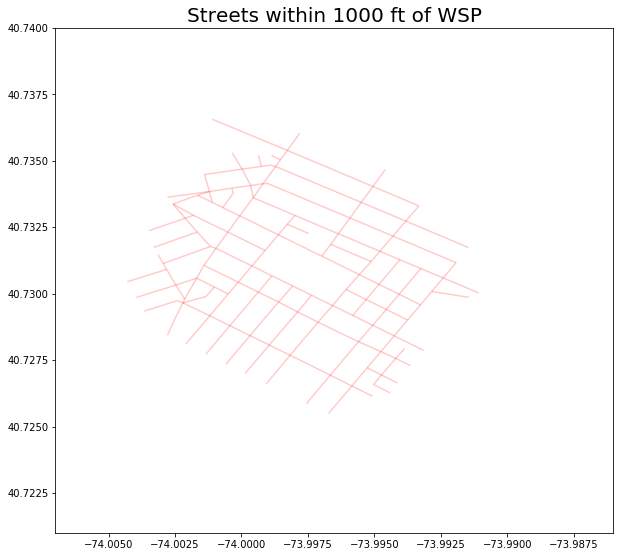

In [75]:
f, ax = plt.subplots(figsize=(10,10))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.007,-73.986))
ax.set_ylim((40.721,40.74))
WSP_st_buffer.plot(ax=ax, color='r', alpha = 0.2)

plt.title("Streets within 1000 ft of WSP", size=20)
plt.show()

### Street Construction Permits

In [ ]:
# STREET CONSTRUCTION PERMITS
# NOT ASSOCIATED WITH ANY BBL
endpoint = 'https://data.cityofnewyork.us/resource/f3ru-yckp.json'

domain = 'data.cityofnewyork.us'
data_id = 'f3ru-yckp'
token = myToken
client = Socrata(domain, token)

metadata = client.get_metadata(data_id)
columns = [x['name'] for x in metadata['columns']]
meta_amount = [x for x in metadata['columns'] if x['name'] == 'BoroughName'][0]
#a = round(401860/50000) + 1

In [ ]:
a=1
results = []
for i in range(a):
    query ="""
    select
        boroughname,
        createdon,
        fromstreetname, issuedworkenddate, issuedworkstartdate,
        onstreetname,permithousenumber, permitissuedate,
        permitstatusid, permitlinearfeet,
        permitteename, tostreetname
    where
        boroughname = 'MANHATTAN'
    limit
        50000
    offset
        {}
    """.format(i*50000)
    results = results + client.get(data_id, query=query)
    print("Total number of non-null results: {}".format(meta_amount['cachedContents']['not_null']))
    print("Number of results downloaded: {}".format(len(results)))

permits = pd.DataFrame(results)

In [ ]:
permits.dropna(subset=['onstreetname'],inplace=True)
streetSet = {i for i in permits['onstreetname']}

## Data Cleaning

In [76]:
## Finding the index of complaints where lat/long is missing 
## & there is address info

fill_address = complaints[((complaints.latitude.isna()) | 
                           (complaints.longitude.isna()))].index

In [77]:
def numberedst(s):
    x = None
    for stype in [' AVENUE',' STREET']:
        if stype in s:
            a = s.split(stype)[0]
            b = list(filter(None, a.split(' ')))
            for seg in b:
                if seg[-1] == '1':
                    x = reduce(lambda x, y: x +' ' + y, b) + 'st' + stype
                elif seg[-1] == '2':
                    x = reduce(lambda x, y: x +' ' + y, b) + 'nd' + stype
                elif seg[-1] == '3':
                    x = reduce(lambda x, y: x +' ' + y, b) + 'rd' + stype
                elif seg.isdigit() == True:
                    x = reduce(lambda x, y: x +' ' + y, b) + 'th' + stype
    if x:
        return x
    else:
        return s

In [78]:
for i in fill_address:
    street = complaints['incident_address'][i]
    crossSt = complaints['cross_street_1'][i]
        
    if complaints['incident_address'][i] != complaints['street_name'][i]:
        loc = geolocator.geocode(street + ', NY')
        complaints['latitude'][i] = loc.latitude
        complaints['longitude'][i] = loc.longitude
        continue
        
    street = numberedst(street)
    crossSt = numberedst(crossSt)
    
    try:
        loc = geolocator.geocode(street + ' & ' + crossSt + ', NY')
        complaints['latitude'][i] = loc.latitude
        complaints['longitude'][i] = loc.longitude
    except:
        try:
            crossSt = numberedst(complaints['cross_street_2'][i])
            
            loc = geolocator.geocode(street+ ' & '+ crossSt + ', New York')
            complaints['latitude'][i] = loc.latitude
            complaints['longitude'][i] = loc.longitude
        except:
            print(i, street, crossSt)    
            continue

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


18309 HORATIO STREET HUDSON STREET
23077 COOPER SQUARE EAST 5th STREET
25916 COOPER SQUARE EAST 5th STREET
27709 COOPER SQUARE EAST 5th STREET
56683 BETHUNE STREET WEST STREET
56871 BETHUNE STREET WEST STREET
56875 BETHUNE STREET WEST STREET
81367 6th AVENUE BLEEKER STREET
86640 6th AVENUE BLEEKER STREET
89829 6th AVENUE BLEECKER STREET
96490 BOWERY STANTON STREET
137681 JANE STREET GREENWICH STREET
211606 AVENUE OF THE AMERICAS BLEECKER STREET
259108 AVENUE OF THE AMERICAS BLEECKER STREET
326940 AVENUE OF THE AMERICAS BLEECKER STREET


Cooper Square, Bethune Street, and Jane Street are all farther than 1000 feet from Washington Square Park, therefore we don't need to geocode them. However, Bleecker & 6th Ave (Ave of Americas) is quite close to WSP, so I will enter an arbitrary address for those entries.

In [79]:
loc = geolocator.geocode('268 6th Ave, New York, NY 10014')
for i in [211606,259108 ,326940]:
    complaints['latitude'][i] = loc.latitude
    complaints['longitude'][i] = loc.longitude

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
complaints.dropna(subset=['longitude', 'latitude'],inplace=True)
complaints['created_date'] = pd.to_datetime(complaints['created_date'])
complaints['createdate'] = complaints['created_date'].apply(lambda x: x.date())
#complaints = complaints[complaints.createdate >= datetime.datetime(2018,1,1)]
#complaints = complaints[complaints.createdate < datetime.datetime(2019,1,1)]
complaints['lonlat']=list(zip(complaints.longitude.astype(float), complaints.latitude.astype(float)))
complaints['geometry']=complaints[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
crs = {'init':'epsg:4326', 'no_defs': True}
complaints = gp.GeoDataFrame(complaints, crs=crs, geometry=complaints['geometry'])


In [81]:
## Perform spatial join of the complaints to the Washington Square Buffer
WSP_buffer.crs = complaints.crs
complaints = sjoin(complaints, WSP_buffer)

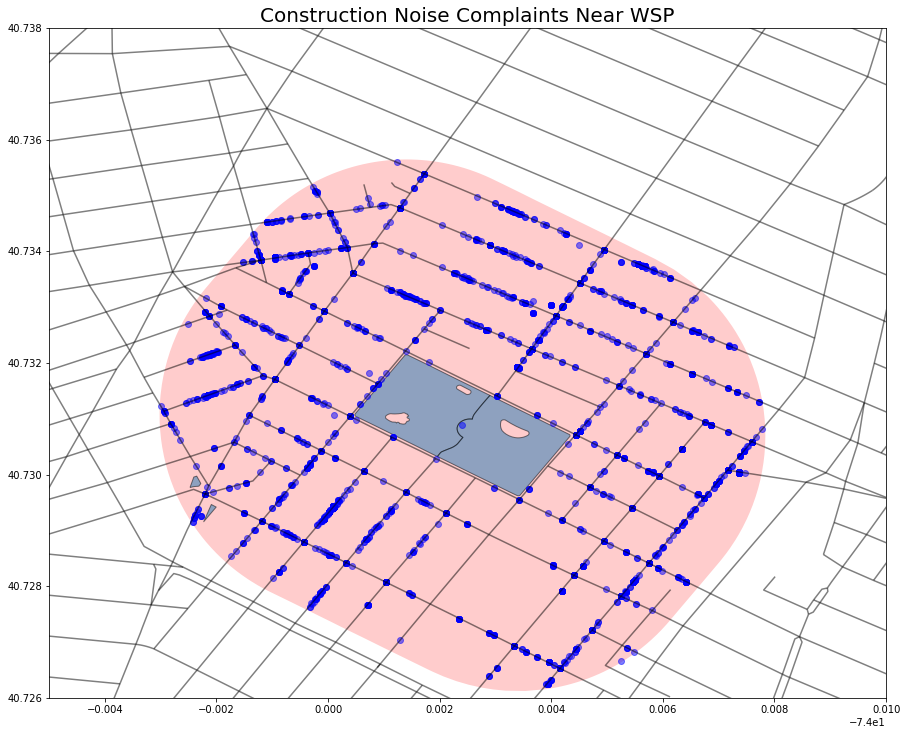

In [82]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.005,-73.99))
ax.set_ylim((40.726,40.738))
WSP_buffer.plot(ax=ax, color='r', alpha = 0.2)
streets.plot(ax=ax, color = 'k', alpha = 0.5)
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')
complaints.plot(ax=ax, color='blue', alpha = 0.5, label='Complaints')

plt.title("Construction Noise Complaints Near WSP", size=20)
plt.show()

## Node-Complaint Association

SONYC has set up sensors around the WSP area to collect decibel data from the ongoing construction project in the area. 
We want to group noise complaints that were made within a certain proximity of these sensor nodes to identify if there is indeed a correlation between actual noise decibel data and complaints.

Text(0.5,1,'Construction Noise Complaints Near WSP')

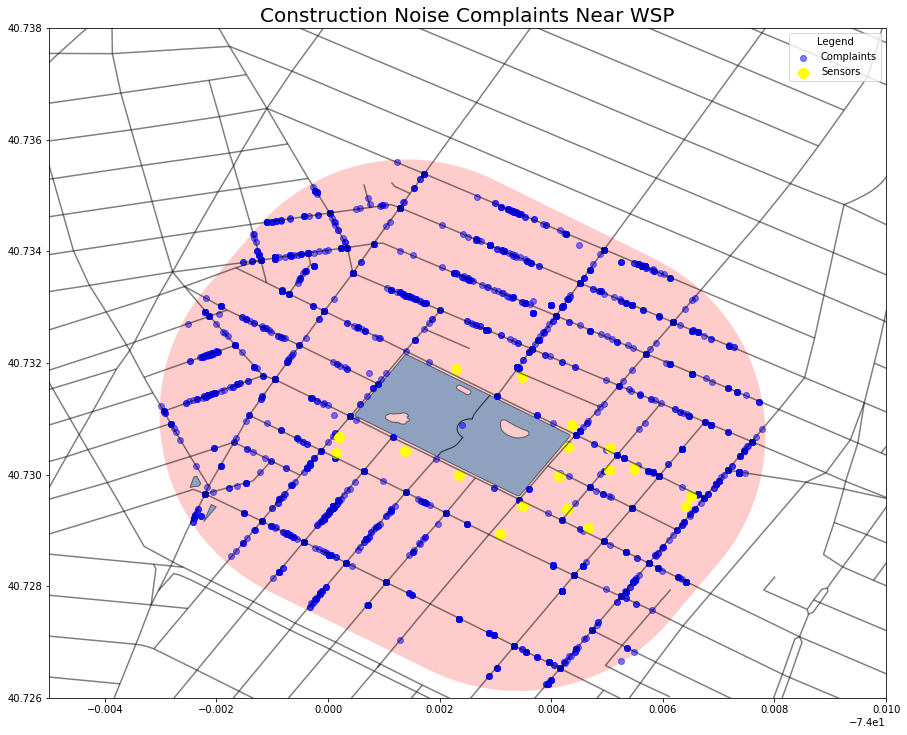

In [83]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.005,-73.99))
ax.set_ylim((40.726,40.738))
WSP_buffer.plot(ax=ax, color='r', alpha = 0.2, label = 'WSP Buffer', legend=True)
streets.plot(ax=ax, color = 'k', alpha = 0.5)
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP', legend = True)
complaints.plot(ax=ax, color='blue', alpha = 0.5, label='Complaints', legend=True)
nodes.plot(ax=ax, color= 'yellow',markersize=100, label = 'Sensors', legend=True)

ax.legend(title="Legend")

plt.title("Construction Noise Complaints Near WSP", size=20)

### Create Buffers Surrounding Nodes

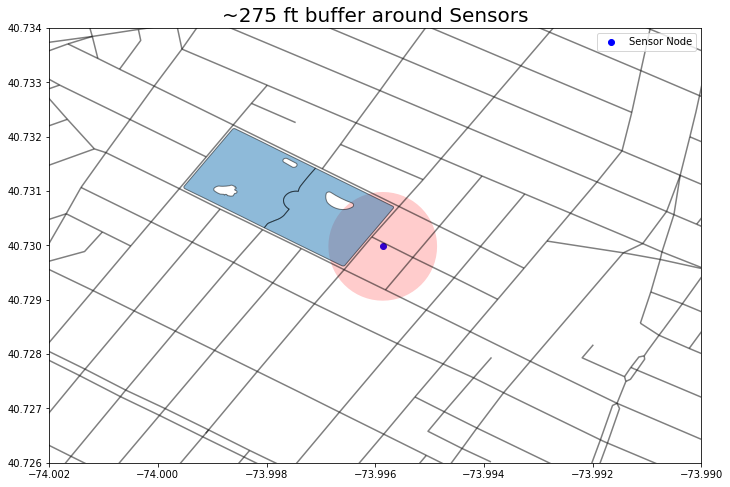

In [84]:
f, ax = plt.subplots(figsize=(12,8))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.002,-73.99))
ax.set_ylim((40.726,40.734))
nodes[nodes.index==0].plot(ax=ax,color='b', label = 'Sensor Node')
nodes[nodes.index==0].buffer(0.0010).plot(ax=ax, color='r', alpha = 0.2,
                                         label = 'Sensor buffer')
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')
streets.plot(ax=ax, edgecolor='k',alpha=0.5)
ax.legend()
plt.title("~275 ft buffer around Sensors", size=20)
plt.show()

In [85]:
node_buffer = nodes.copy()
for i in nodes.index:
    node_buffer['geometry'][i] = node_buffer['geometry'][i].buffer(0.0010)



/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
complaints.drop(columns = ['address_type', 'community_board', 'complaint_type', 'incident_zip', 'intersection_street_1', 'intersection_street_2',
       'latitude', 'location_type', 'longitude','index_right', 'propname'],inplace=True)


In [96]:
node_complaints = sjoin(complaints, node_buffer)

In [88]:
nodeBuffers = gp.GeoSeries(cascaded_union(node_buffer.geometry))

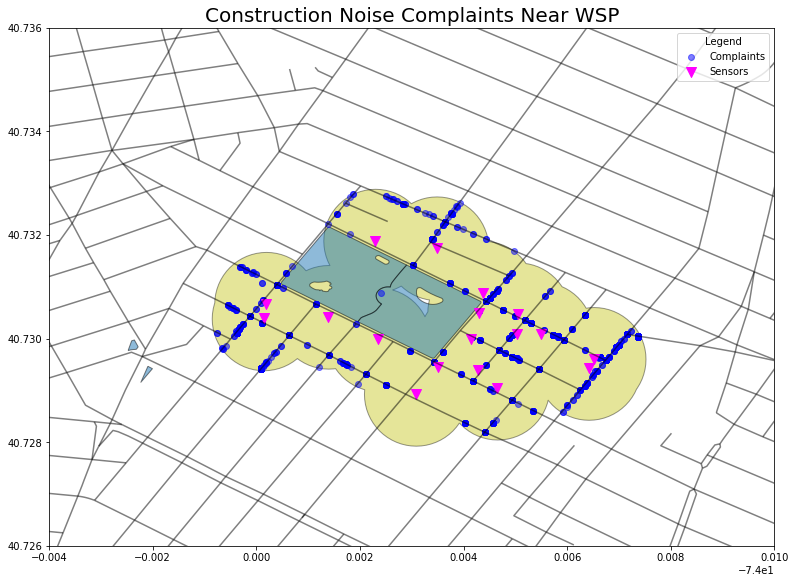

In [103]:
f, ax = plt.subplots(figsize=(13,11))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim((-74.004,-73.99))
ax.set_ylim((40.726,40.736))
nodeBuffers.plot(ax=ax, color='y', edgecolor = 'k',alpha = 0.4, label = 'Node Buffer')
streets.plot(ax=ax, color = 'k', alpha = 0.5)
nycParks.plot(ax=ax, edgecolor='k',alpha=0.5, label='WSP')
node_complaints.plot(ax=ax, color='blue', alpha = 0.5, label='Complaints')
nodes.plot(ax=ax, color= 'magenta',marker = 'v',
           markersize=100,label = 'Sensors')

ax.legend(title='Legend')

plt.title("Construction Noise Complaints Near WSP", size=20)
plt.show()

In [105]:
node_complaints_daily = pd.DataFrame(
    node_complaints.groupby(['index_right','createdate'])['created_date'].count())
node_complaints_daily.rename(columns={'created_date':'count'},inplace=True)

#### Daily Noise Complaints within Sensor Buffer Areas
This dataframe will be used to compare with the sensor data to see if the days where there are construction-related complaints, there is a period of excessive noise that occurred.

In [130]:
node_complaints_daily

count
index_right createdate       
0           2010-01-29      1
            2010-04-22      1
            2010-05-04      4
            2010-05-25      1
            2010-09-27      2
            2010-10-12      3
            2010-11-17      1
            2010-12-04      1
            2011-09-01      1
            2011-09-11      1
            2011-11-10      1
            2012-03-22      1
            2012-04-04      1
            2012-05-02      1
            2012-05-06      1
            2012-06-27      1
            2012-07-24      1
            2012-09-13      1
            2012-11-10      1
            2013-04-04      3
            2014-06-17      1
            2014-07-23      2
            2014-08-16      1
            2014-08-18      1
            2014-08-19      1
            2015-02-14      1
            2015-10-06      1
            2015-11-10      1
            2016-01-11      1
            2016-01-12      1
...                       ...
16          2018-11-09      1
            2018-11-12      1
            2018-11-16      1
17          2010-02-13      1
            2011-01-19      1
            2011-04-20      1
            2011-04-21      1
            2011-06-15      1
            2011-07-01      1
            2011-07-15      1
            2011-10-24      1
            2012-01-10      1
            2012-04-04      1
            2012-04-09      1
            2013-01-13      1
            2014-02-28      1
            2014-03-08      1
            2014-08-22      1
            2014-12-15      1
            2015-10-09      1
            2015-10-10      1
            2016-01-07      1
            2016-01-08      2
            2016-01-11      3
            2016-08-23      1
            2017-03-28      1
            2017-04-23      1
            2017-05-17      1
            2018-04-25      4
            2018-12-03      1

[1190 rows x 1 columns]

In [123]:
node_complaints['month'] = node_complaints['created_date'].apply(lambda x: x.month)

In [128]:
node_complaints_monthly = pd.DataFrame(
    node_complaints.groupby(['index_right','month'])['created_date'].count())
node_complaints_monthly.rename(columns={'created_date':'count'},inplace=True)

In [129]:
node_complaints_monthly

count
index_right month       
0           1          7
            2          8
            3         12
            4          8
            5         10
            6          4
            7          3
            8          8
            9          5
            10         6
            11         5
            12         3
1           1         14
            2         13
            3         13
            4         23
            5         12
            6          4
            7          7
            8         13
            9          9
            10        23
            11         7
            12         6
2           1         12
            2         11
            3         12
            4         11
            5          7
            6          4
...                  ...
15          4          6
            5         12
            6          4
            7          4
            8          9
            9          4
            10         7
            11         5
            12         4
16          1         11
            2         17
            3         15
            4          3
            5          4
            6          9
            7          1
            8          3
            9          8
            10         4
            11        18
17          1          9
            2          2
            3          2
            4          9
            5          1
            6          1
            7          2
            8          2
            10         3
            12         2

[200 rows x 1 columns]